THIS NOTEBOOK IS FOR PROJECT WORK IN THE COURSE SSY340:

This code downloads OGB-products benchmark dataset and trains and evaluates the performance of three different networks; One MLP, one GNN with GCNConv layers and one GNN with SAGEConv layers.

In the end the metrics from training and testing the models are saved!

Written by: Albin Steen and Anthon Odengard

Date: 20-10-2024

In [1]:
# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
from ogb.nodeproppred import PygNodePropPredDataset
import torch
import torch_geometric
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import GCNConv, SAGEConv
import torch.nn.functional as F
import torch.nn as nn
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import pickle

In [2]:
# GET DATASET #################
# This assumes that you have installed ogb library!
dataset = PygNodePropPredDataset(name = 'ogbn-products')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print('=============================================================')
data = dataset[0]  # Get one data point.

print('Some properties of a graph in the dataset:')

print(data)
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of node features: {data.num_node_features}')
###############################

Number of graphs: 1
Some properties of a graph in the dataset:
Data(num_nodes=2449029, edge_index=[2, 123718280], x=[2449029, 100], y=[2449029, 1])
Number of nodes: 2449029
Number of edges: 123718280
Average node degree: 50.52
Number of node features: 100


In [3]:
#### GET LOADERS #####################
split_idx = dataset.get_idx_split()
train_idx, valid_idx, test_idx = split_idx["train"], split_idx["valid"], split_idx["test"]
data = dataset[0] # pyg graph object

# These loaders help to implement mini-batch training for graphs by creating subgraphs with specified number of neighbours in each layer
#Prepare loaders
train_loader = NeighborLoader(
    data,
    input_nodes=split_idx['train'],
    num_neighbors=[15, 10, 5], 
    batch_size=2048,
    shuffle=True)

validation_loader = NeighborLoader(
    data,
    input_nodes = split_idx['valid'],
    num_neighbors =[-1], #This means include all neighbours
    batch_size = 2048)


test_loader = NeighborLoader(
    data,
    input_nodes = split_idx['test'],
    num_neighbors =[-1],
    batch_size = 2048)
#########################################

In [4]:
class MetricObject():

    def __init__(self):
        self.accuracy = []
        self.loss = []
        self.acc_metric = 0.0
        self.loss_metric = 0.0
        self.counter = 0

    def add_metrics(self, acc, loss):
        self.acc_metric += acc
        self.loss_metric += loss
        self.counter += 1

    def collect_avg(self):
        self.accuracy.append(self.acc_metric / self.counter)
        self.loss.append(self.loss_metric / self.counter)
        self.counter = 0
        self.acc_metric = 0.0
        self.loss_metric = 0.0


# This class is used to process all the networks in different ways ie training, testing etc
class NetworkProcesser():

    def __init__(self, type_model, optimizer, loss_fn, model: torch.nn.Module, loaders: list):
        self.model_train_metric = MetricObject()
        self.model_val_metric = MetricObject()
        self.model_test_metric = MetricObject()
        self.train_loader, self.val_loader, self.test_loader = loaders
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.type_model = type_model
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)

    def accuracy(self, pred, label):
        hard_pred = pred.argmax(1)
        return (hard_pred == label).float().mean().item()

    def train_loop_epoch(self):

        self.model.train()
        for batch in self.train_loader:
            self.optimizer.zero_grad()

            if self.type_model == 'mlp':
                pred = self.model(batch.x[:batch.batch_size].to(self.device))
            else:
                pred = self.model(batch.x.to(self.device), batch.edge_index.to(self.device))

            pred = pred[:batch.batch_size]
            labels = batch.y[:batch.batch_size].squeeze().to(self.device)
            loss = self.loss_fn(pred, labels)
            acc = self.accuracy(pred, labels)
            self.model_train_metric.add_metrics(acc, loss.item())

            loss.backward()
            self.optimizer.step()

        self.model_train_metric.collect_avg()


    def val_loop_epoch(self):

        self.model.eval()
        with torch.no_grad():
            for batch in self.val_loader:
                if self.type_model == 'mlp':
                    pred = self.model(batch.x[:batch.batch_size].to(self.device))
                else:
                    pred = self.model(batch.x.to(self.device), batch.edge_index.to(self.device))

                pred = pred[:batch.batch_size]
                labels = batch.y[:batch.batch_size].squeeze().to(self.device)
                loss = self.loss_fn(pred, labels)
                acc = self.accuracy(pred, labels)
                self.model_val_metric.add_metrics(acc, loss.item())

            self.model_val_metric.collect_avg()


    def test_loop_epoch(self):

        preds = []
        all_labels = []

        self.model.eval()
        with torch.no_grad():
            for index, batch in enumerate(self.test_loader):
                if self.type_model == 'mlp':
                    pred = self.model(batch.x[:batch.batch_size].to(self.device))
                else:
                    pred = self.model(batch.x.to(self.device), batch.edge_index.to(self.device))
                    
                pred = pred[:batch.batch_size]
                preds.append(pred.argmax(1))
                labels = batch.y[:batch.batch_size].squeeze().to(self.device)
                all_labels.append(labels)

                acc = self.accuracy(pred, labels)
                self.model_test_metric.add_metrics(acc, 0)

                if index == 0:
                    self.visualize(pred, color=labels)


            self.model_test_metric.collect_avg()
            print("******************************* TESTING: *******************************")
            print(f"TEST ACCURACY: {self.model_test_metric.accuracy[-1]:.5f}")

        

        return preds, all_labels
    

    def train_val_loop(self, epochs: int):

        print(f"Starting training of {self.type_model} on {self.device} : ")
        print("*************************************************************************************")

        for epoch in range(epochs):
            self.train_loop_epoch()
            self.val_loop_epoch()
            print(f"Epoch {epoch+1} /:::/ TRAINING: Accuracy: {self.model_train_metric.accuracy[-1]:.5f}, Loss: {self.model_train_metric.loss[-1]:.5f} /:::/ VALIDATION: Accuracy: {self.model_val_metric.accuracy[-1]:.5f}, Loss: {self.model_val_metric.loss[-1]:.5f}")
            print("*************************************************************************************")
            torch.cuda.empty_cache()


        print("Training COMPLETE!")

    
    def save_model(self):
        torch.save(self.model.state_dict(), f"{self.type_model}_model.pt")

    def plot_metrics(self):
        sns.set_theme(style="darkgrid", palette="muted")

        fig, axs = plt.subplots(1, 2, figsize=(20, 10))

        metrics_train = [self.model_train_metric.accuracy, self.model_train_metric.loss]
        metrics_val = [self.model_val_metric.accuracy, self.model_val_metric.loss]
        labels = ['Accuracy', 'Loss']

        colors = sns.color_palette("coolwarm", 2)

        for ax, train, val, label in zip(axs, metrics_train, metrics_val, labels):
            epochs = np.arange(1, len(train) + 1)

            ax.plot(epochs, train, 'o-', color=colors[0], label=f'{label} (Training)', linewidth=2, markersize=8)
            ax.plot(epochs, val, 'o-', color=colors[1], label=f'{label} (Validation)', linewidth=2, markersize=8)

            ax.set_xlabel("Epochs", fontsize=14)
            ax.set_ylabel(f"{label}", fontsize=14)
            ax.set_title(f"{label} for Training vs Validation", fontsize=16)
            ax.legend(fontsize=12)

        plt.tight_layout()
        plt.show()

    # The following method is a bit out of the ordinary, it simply uses TSNE which is a visualization technique for projecting high dimensional data into 2 dimensions
    # Furthermore, it is called only for the first batch when testing the models to get a visualization of how the networks embedded the different nodes!
    def visualize(self, h, color, training=False, sample_size=2000):

        """
        This function is very much inspired by a function from https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX?usp=sharing

        """
        if h.size(0) > sample_size:
            indices = torch.randperm(h.size(0))[:sample_size]
            h = h[indices]
            color = color[indices]  # This may also be a tensor, so we handle it later
    
        # Move the tensor to CPU and convert to NumPy array
        z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    
        # Ensure color is also a NumPy array
        color = color.detach().cpu().numpy() if isinstance(color, torch.Tensor) else color
    
        sns.set_theme(style="darkgrid", context="poster")
    
        plt.figure(figsize=(20, 20))
        plt.xticks([])
        plt.yticks([])
        plt.title(f"Node embeddings for {self.type_model}-model, training: {training}")
    
        # Use color in the scatter plot
        plt.scatter(z[:, 0], z[:, 1], s=120, c=color, cmap="Set2")
        plt.show()


In [5]:
#### LETS BUILD SOME NETWORKS ####


class MLP(torch.nn.Module):

    def __init__(self, inputs: int, outputs: int, hidden: int, nr_of_layers: int, dropout_perc=0.5):
        super().__init__()
        torch.manual_seed(12345)
        self.input = inputs
        self.output = outputs
        self.hidden = hidden
        self.p = dropout_perc


        # LAYERS
        self.layers = nn.ModuleList()
        self.input_layer = nn.Linear(self.input, self.hidden)
        self.output_layer = nn.Linear(self.hidden, self.output)

        self.layers.append(self.input_layer)
        for i in range(nr_of_layers):
            self.layers.append(nn.Linear(self.hidden, self.hidden))
        self.layers.append(self.output_layer)


        #ACTIVATIONS
        self.relu = nn.ReLU()



        #OTHER

    def reset_parameters(self):
        for layer in self.layers:
            layer.reset_parameters()

    def forward(self, x):
        
        for layer in self.layers[:-1]:
            x = F.dropout(self.relu(layer(x)), p=self.p, training=self.training) # We only apply relu and potential dropout on all layers except the last one

        x = self.layers[-1](x)
        return x
    



class GCN(torch.nn.Module):


    def __init__(self, inputs: int, outputs: int, hidden: int, nr_of_layers:int, dropout_perc=0.5):
        super().__init__()
        torch.manual_seed(12345)
        self.input = inputs
        self.output = outputs
        self.hidden = hidden
        self.p = dropout_perc

        # LAYERS
        self.layers = nn.ModuleList()
        self.input_layer = GCNConv(self.input, self.hidden)
        self.output_layer = GCNConv(self.hidden, self.output)

        self.layers.append(self.input_layer)
        for i in range(nr_of_layers):
            self.layers.append(GCNConv(self.hidden, self.hidden))
        self.layers.append(self.output_layer)


        #ACTIVATIONS
        self.relu = nn.ReLU()


        #OTHER

    def reset_parameters(self):
        for layer in self.layers:
            layer.reset_parameters()

    def forward(self, x, edge_index):
        
        for layer in self.layers[:-1]:
            x = F.dropout(self.relu(layer(x, edge_index)), p=self.p, training=self.training)

        x = self.layers[-1](x, edge_index)
        return x

class SAGE(torch.nn.Module):


    def __init__(self, inputs: int, outputs: int, hidden: int, nr_of_layers:int, dropout_perc=0.5):
        super().__init__()
        torch.manual_seed(12345)
        self.input = inputs
        self.output = outputs
        self.hidden = hidden
        self.p = dropout_perc

                # LAYERS
        self.layers = nn.ModuleList()
        self.input_layer = SAGEConv(self.input, self.hidden)
        self.output_layer = SAGEConv(self.hidden, self.output)

        self.layers.append(self.input_layer)
        for i in range(nr_of_layers):
            self.layers.append(GCNConv(self.hidden, self.hidden))
        self.layers.append(self.output_layer)


        #ACTIVATIONS
        self.relu = nn.ReLU()


        #OTHER

    def reset_parameters(self):
        for layer in self.layers:
            layer.reset_parameters()

    def forward(self, x, edge_index):

        for layer in self.layers[:-1]:
            x = F.dropout(self.relu(layer(x, edge_index)), p=self.p, training=self.training)

        x = self.layers[-1](x, edge_index)
        return x

In [6]:
#HERE we calculate the weights for the unbalanced dataset, specifically the weights for the train set
# Ultimately we decided not to use the weights for several reasons

num_classes = dataset.num_classes

# Collect labels from training batches
d = []
for batch in train_loader:
    d.append(batch.y[:batch.batch_size])

flat_tensor = torch.cat(d).flatten()

# Count occurrences of each class in the training set
counts = torch.bincount(flat_tensor, minlength=num_classes)  # Ensure size matches num_classes

ns = counts.float()
w = torch.where(ns > 0, 1.0 / ns, torch.tensor(0.0))
w = w / w.sum()

In [7]:
#### CREATE MODELS #############################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_model = MLP(dataset.num_features, dataset.num_classes, 128, 2, dropout_perc=0.0)
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.001)
mlp_process = NetworkProcesser('mlp', optimizer_mlp, nn.CrossEntropyLoss(), mlp_model, [train_loader, validation_loader, test_loader])
################################################

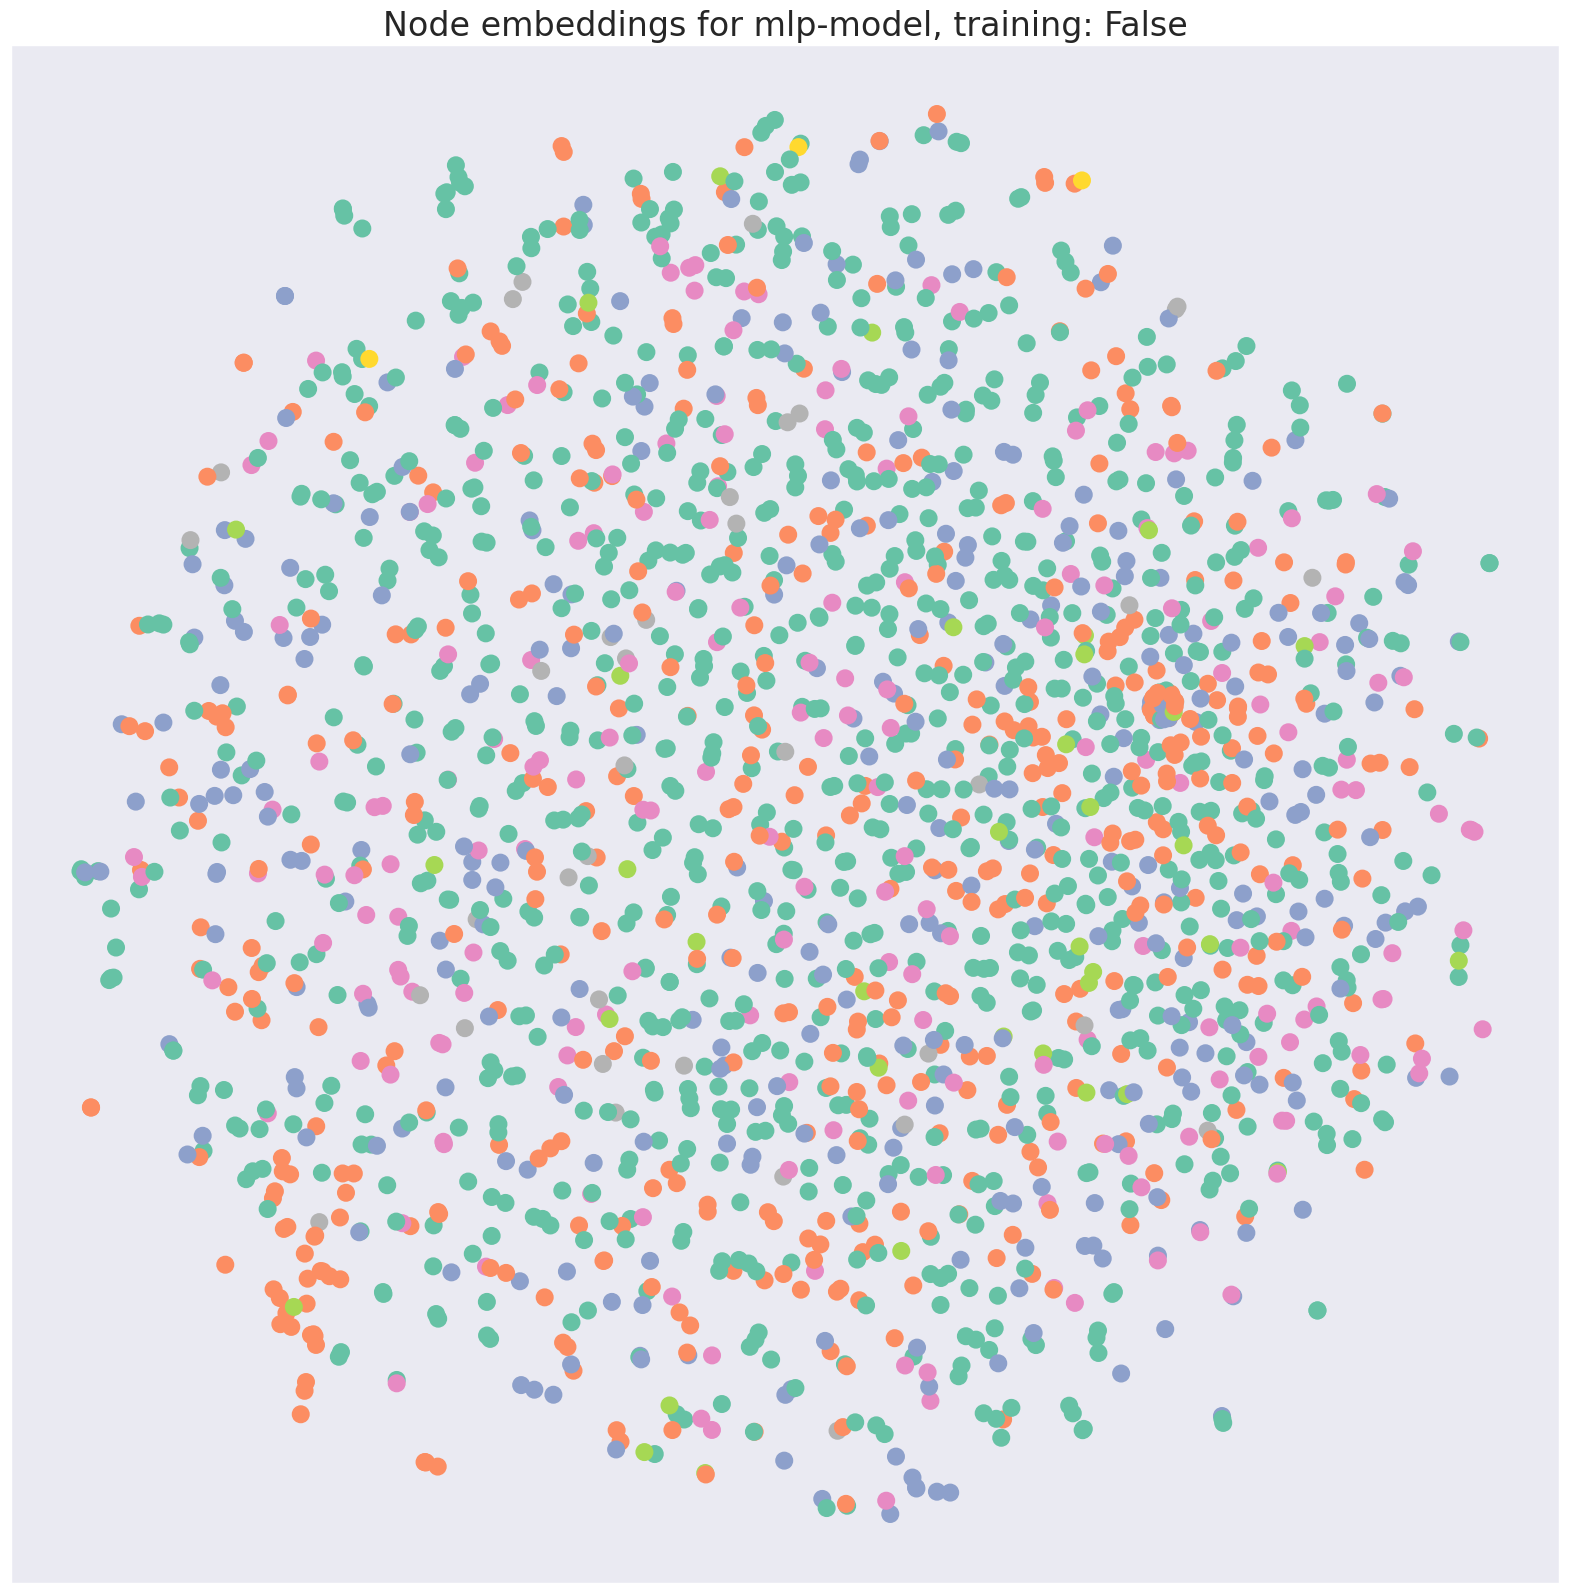

******************************* TESTING: *******************************
TEST ACCURACY: 0.00871
Starting training of mlp on cuda : 
*************************************************************************************
Epoch 1 /:::/ TRAINING: Accuracy: 0.39123, Loss: 2.33033 /:::/ VALIDATION: Accuracy: 0.55471, Loss: 1.62296
*************************************************************************************
Epoch 2 /:::/ TRAINING: Accuracy: 0.61194, Loss: 1.39860 /:::/ VALIDATION: Accuracy: 0.63141, Loss: 1.34054
*************************************************************************************
Epoch 3 /:::/ TRAINING: Accuracy: 0.65886, Loss: 1.20385 /:::/ VALIDATION: Accuracy: 0.66226, Loss: 1.20215
*************************************************************************************
Epoch 4 /:::/ TRAINING: Accuracy: 0.68507, Loss: 1.10675 /:::/ VALIDATION: Accuracy: 0.66885, Loss: 1.15644
*************************************************************************************
Epoch 

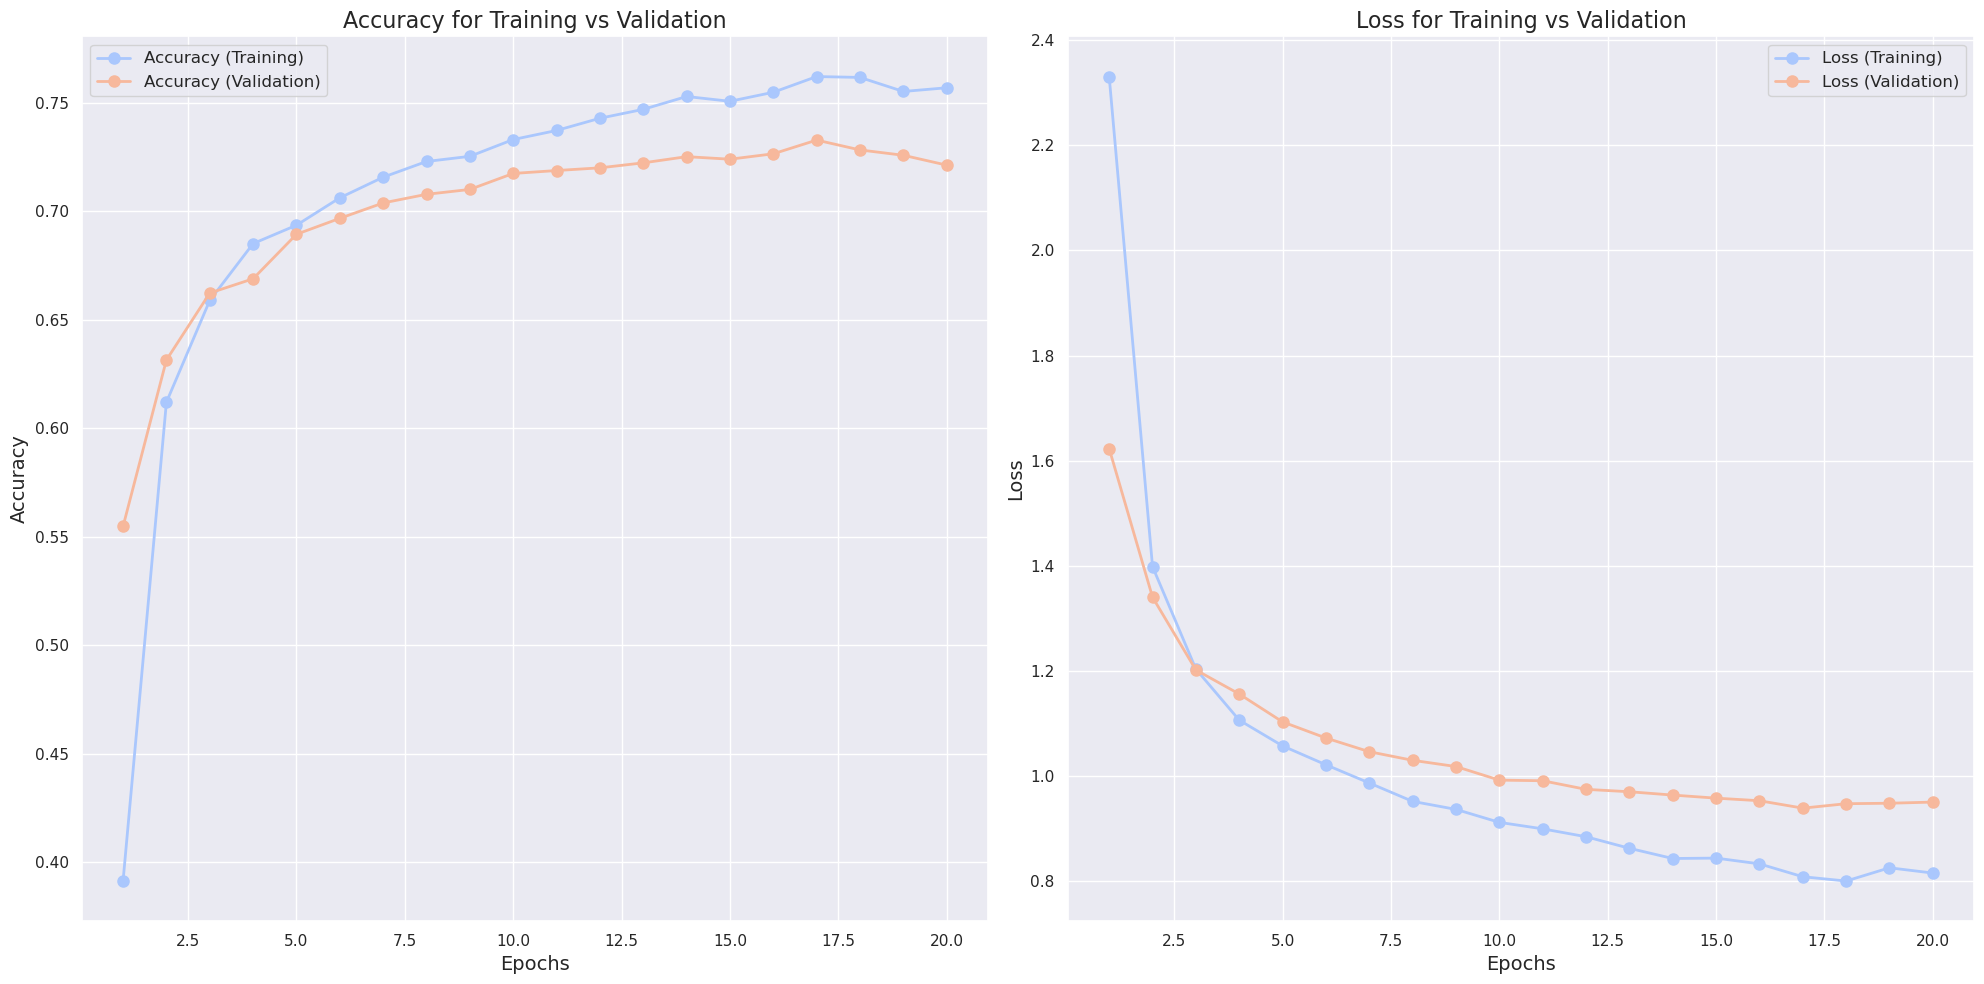

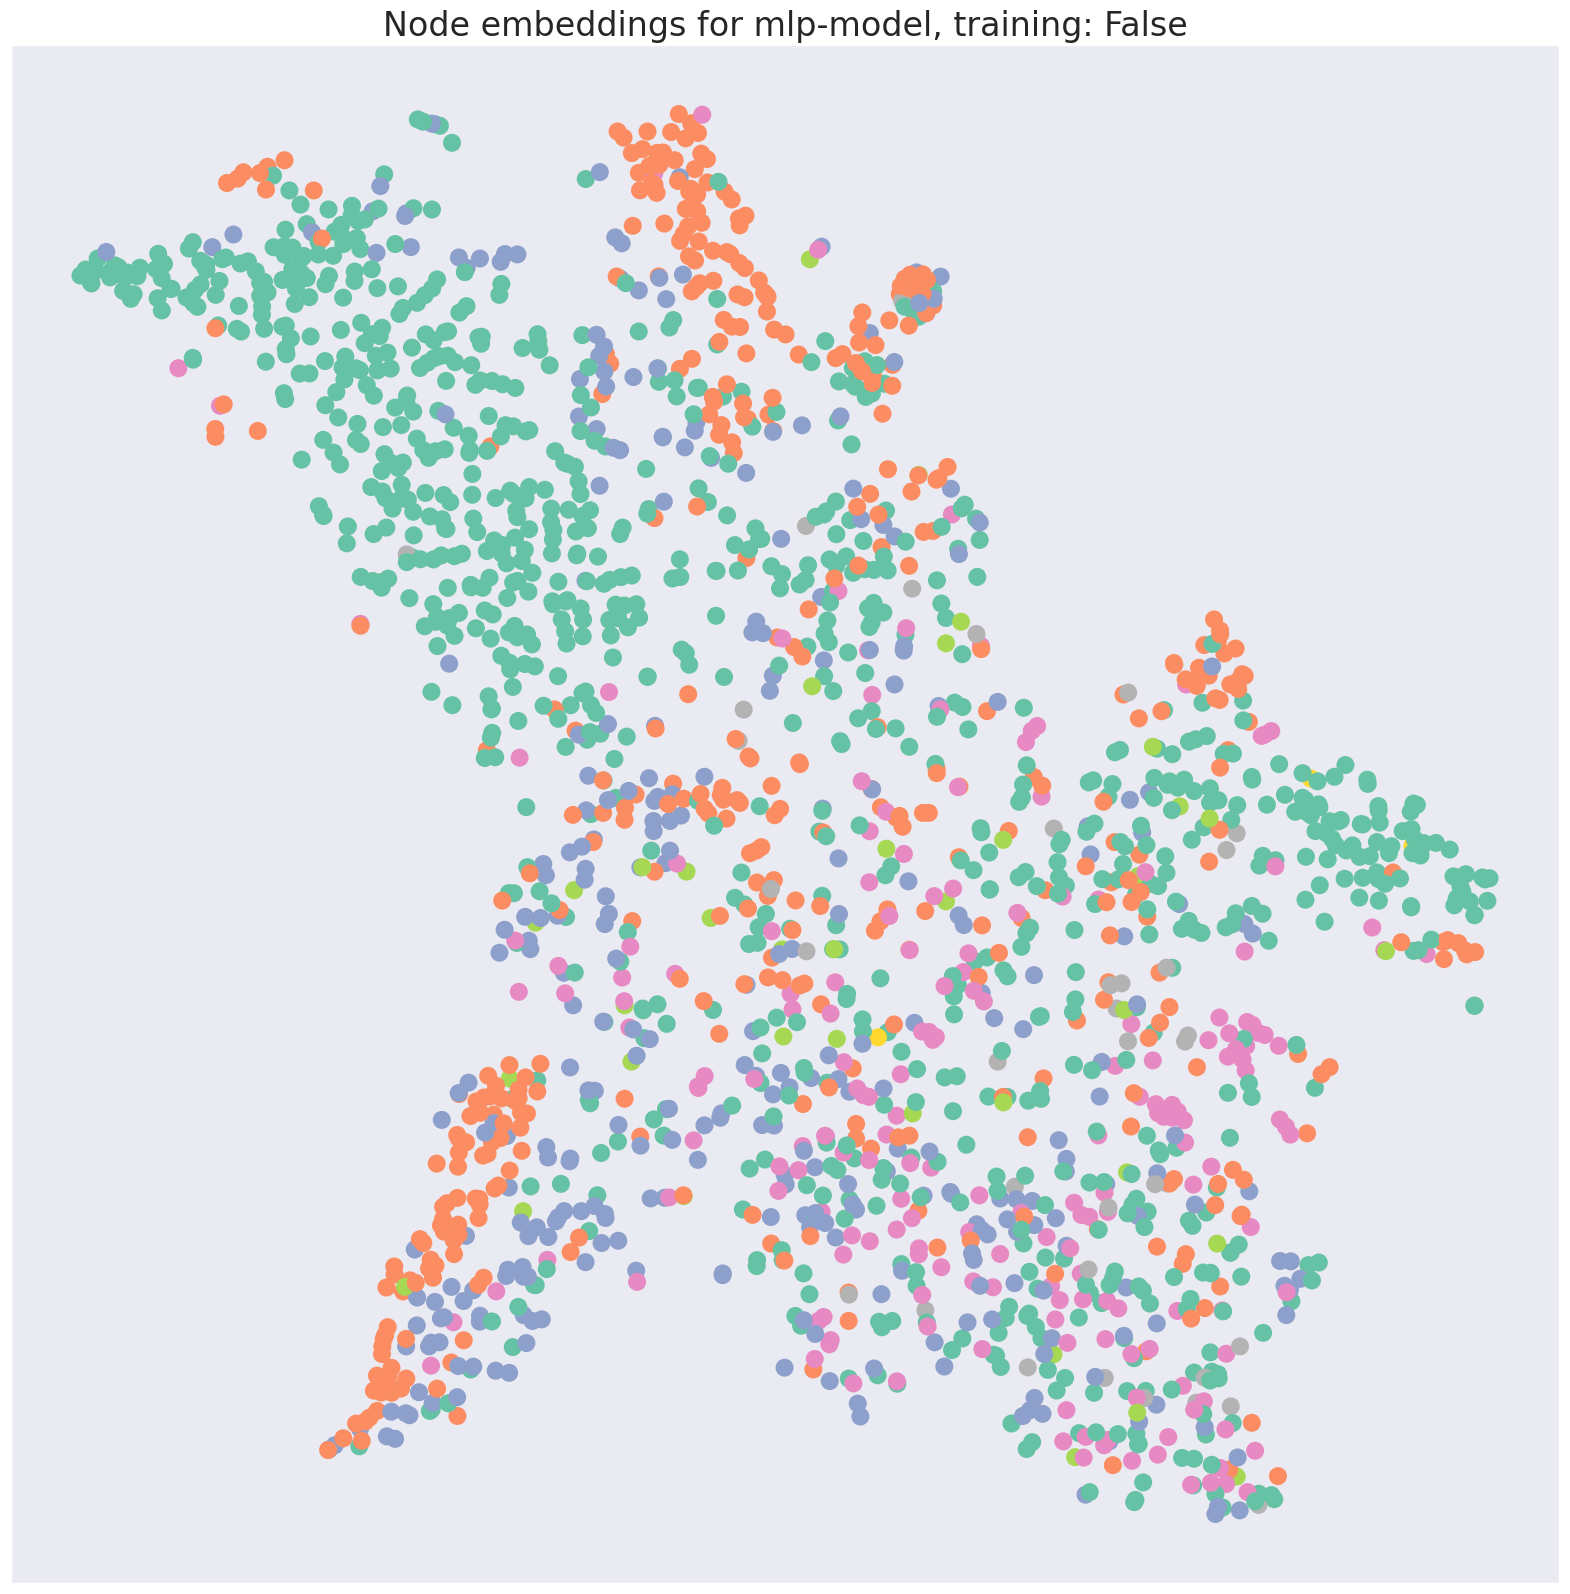

******************************* TESTING: *******************************
TEST ACCURACY: 0.58614


In [8]:
#### TRAIN MLP ##############################
epochs = 20
_, _ = mlp_process.test_loop_epoch()
mlp_process.train_val_loop(epochs)
mlp_process.plot_metrics()
pred_mlp, labels_mlp = mlp_process.test_loop_epoch()
#############################################

In [9]:
#### TRAIN GNN ##############################
gcn_model = GCN(dataset.num_features, dataset.num_classes, 128, 1, dropout_perc=0.6)
optimizer_gcn = torch.optim.Adam(gcn_model.parameters(), lr=0.0005)
gcn_process = NetworkProcesser('gcn', optimizer_gcn, nn.CrossEntropyLoss(), gcn_model, [train_loader, validation_loader, test_loader])
#############################################

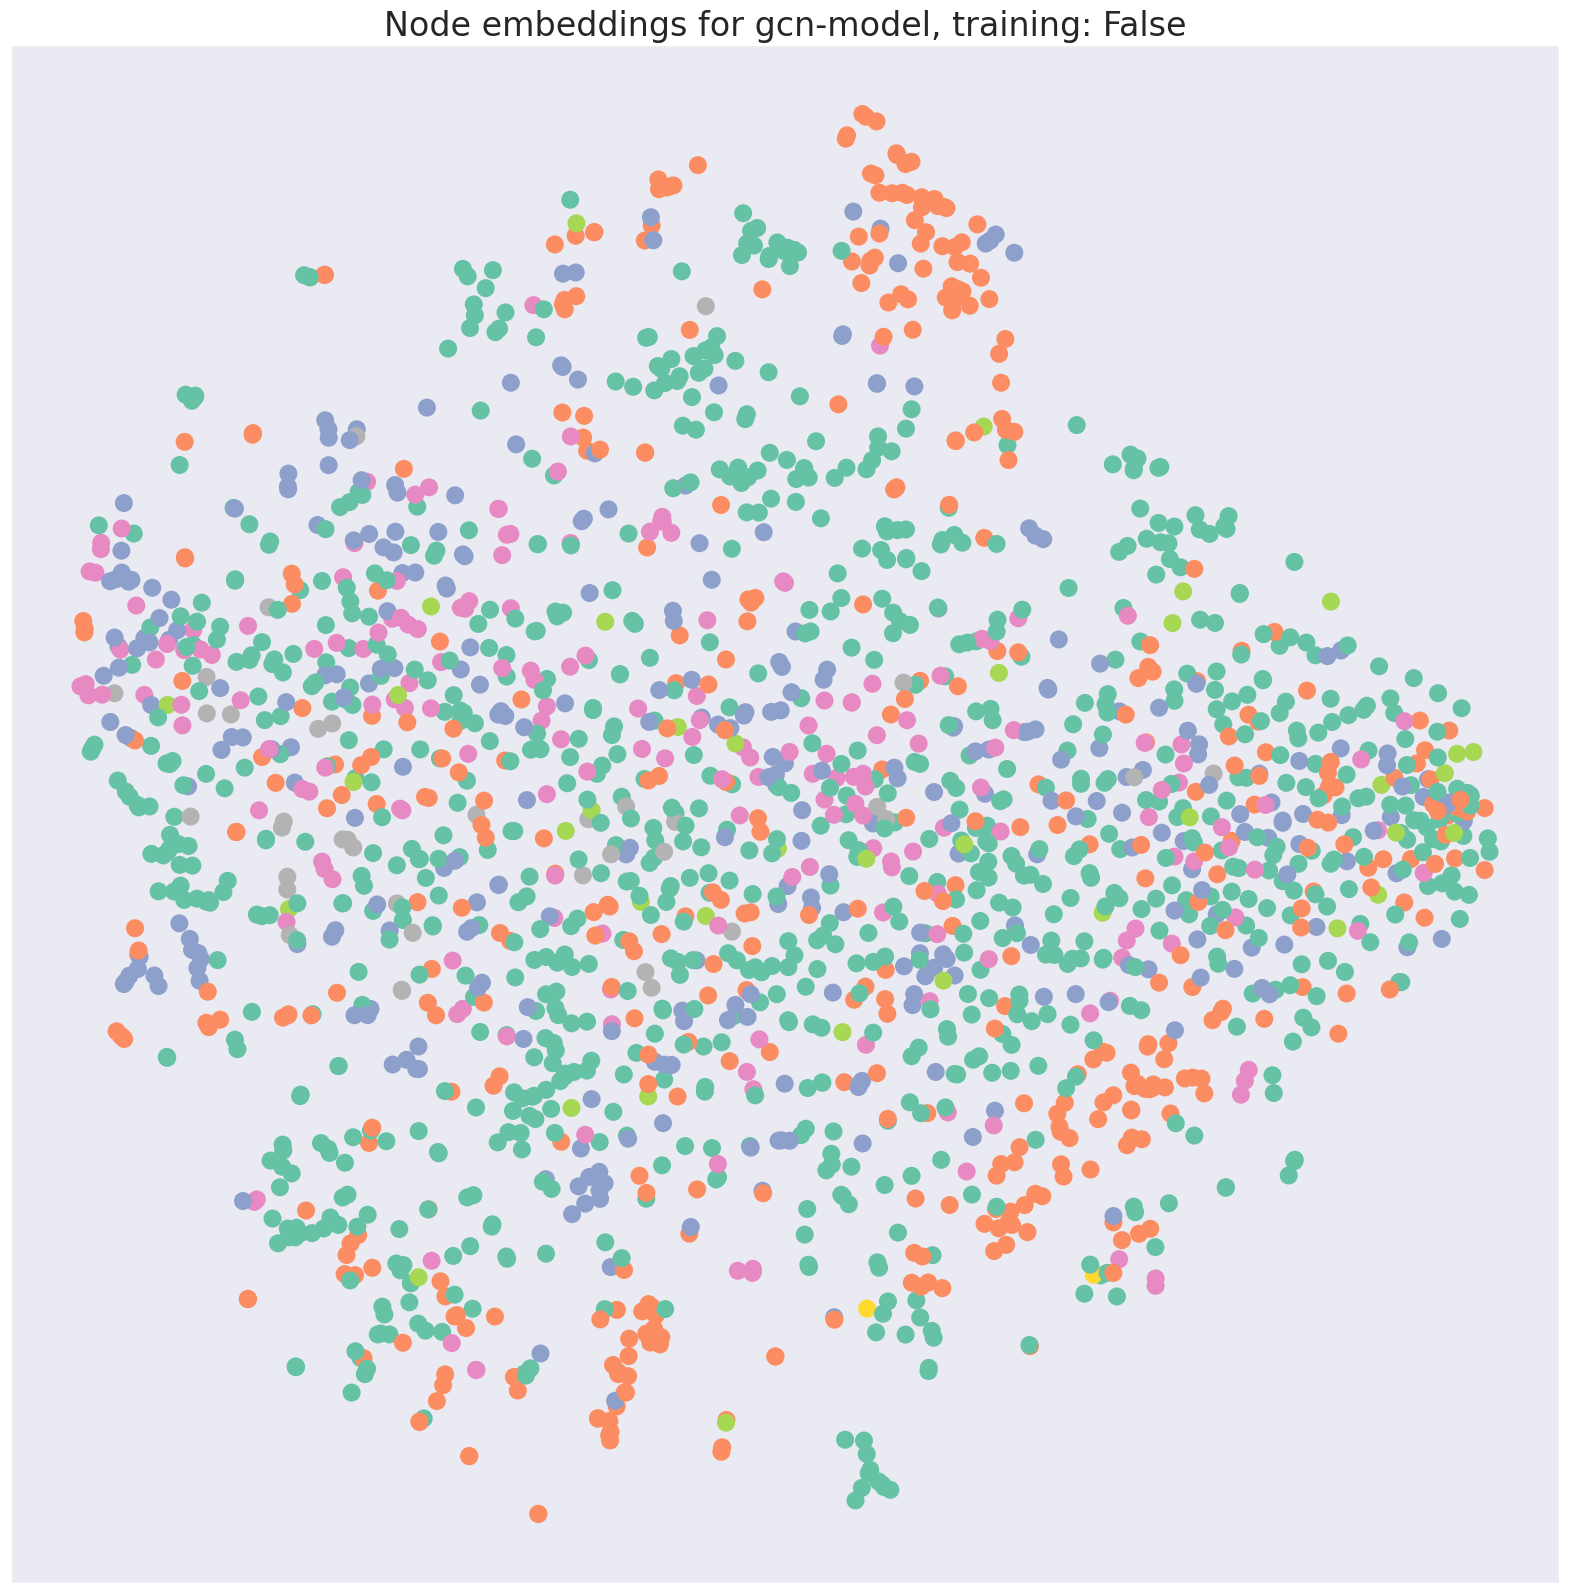

******************************* TESTING: *******************************
TEST ACCURACY: 0.04657
Starting training of gcn on cuda : 
*************************************************************************************
Epoch 1 /:::/ TRAINING: Accuracy: 0.54041, Loss: 1.87535 /:::/ VALIDATION: Accuracy: 0.72142, Loss: 2.20343
*************************************************************************************
Epoch 2 /:::/ TRAINING: Accuracy: 0.81860, Loss: 0.74420 /:::/ VALIDATION: Accuracy: 0.79809, Loss: 1.81083
*************************************************************************************
Epoch 3 /:::/ TRAINING: Accuracy: 0.84885, Loss: 0.59578 /:::/ VALIDATION: Accuracy: 0.80978, Loss: 1.71457
*************************************************************************************
Epoch 4 /:::/ TRAINING: Accuracy: 0.86208, Loss: 0.53427 /:::/ VALIDATION: Accuracy: 0.82137, Loss: 1.62260
*************************************************************************************
Epoch 

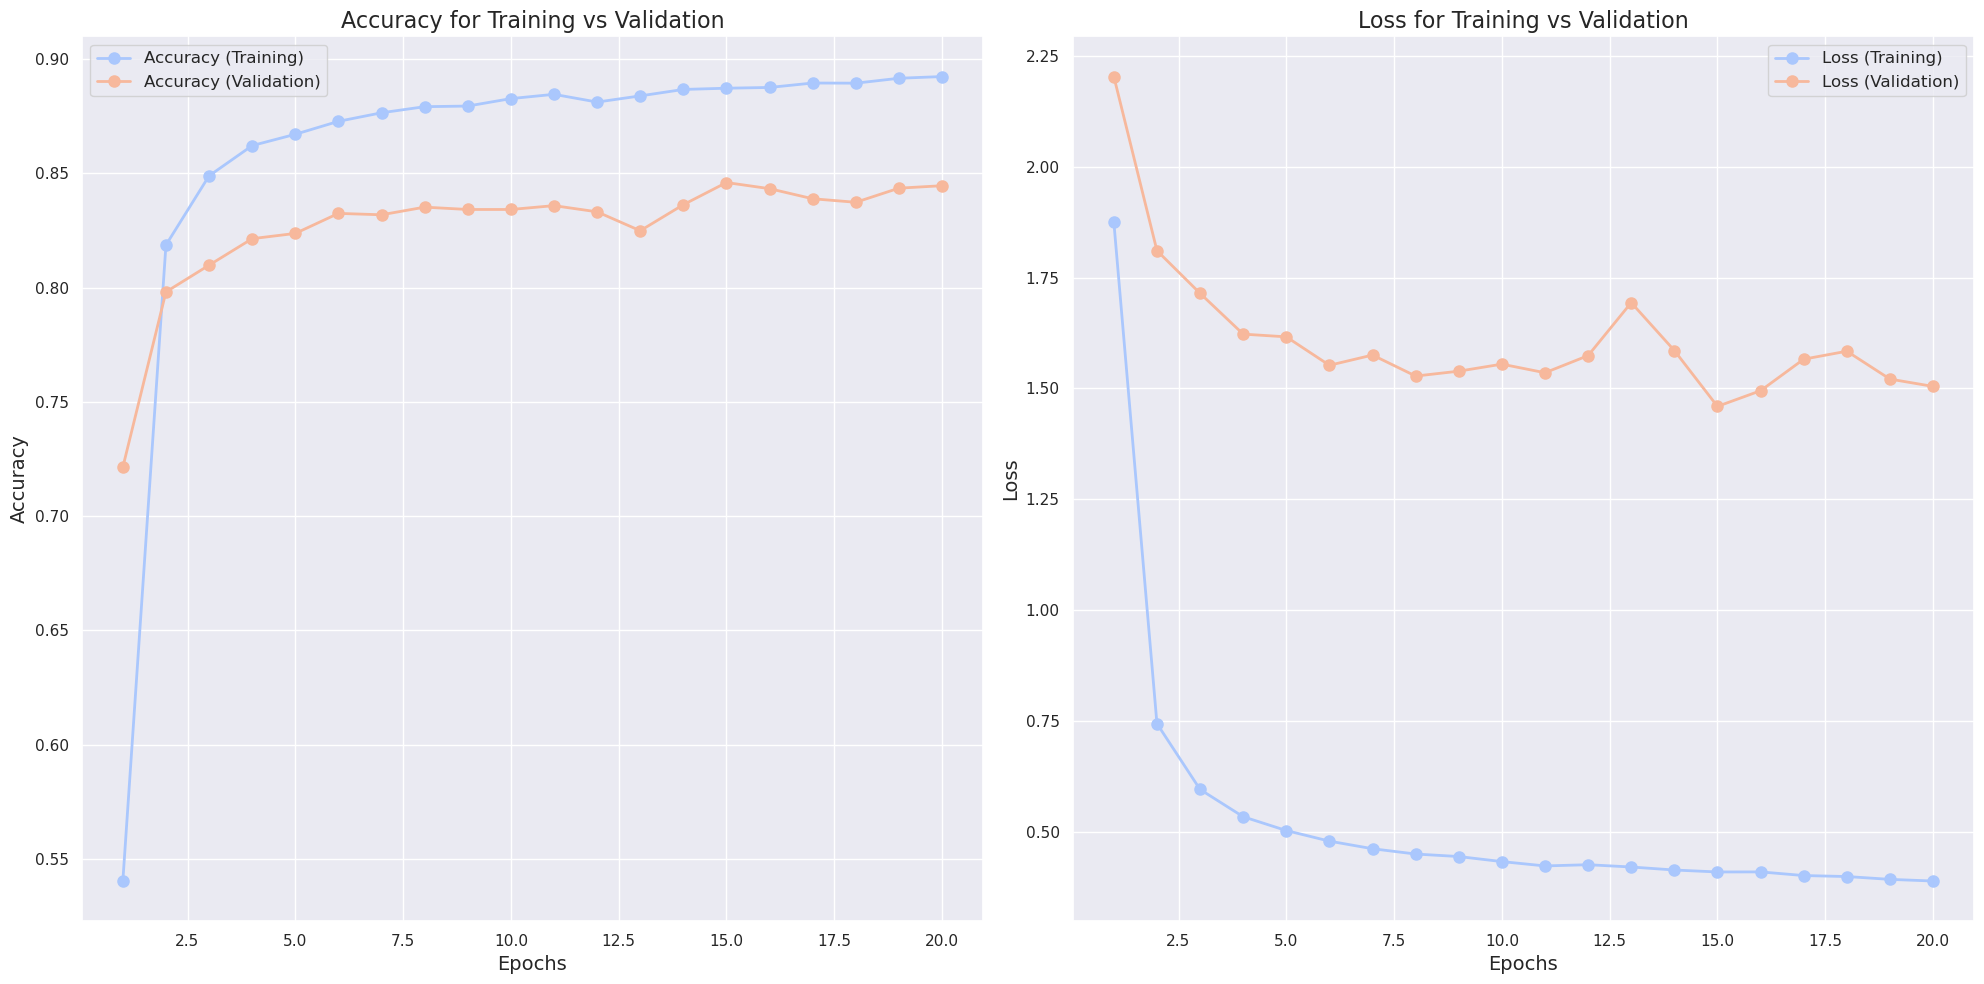

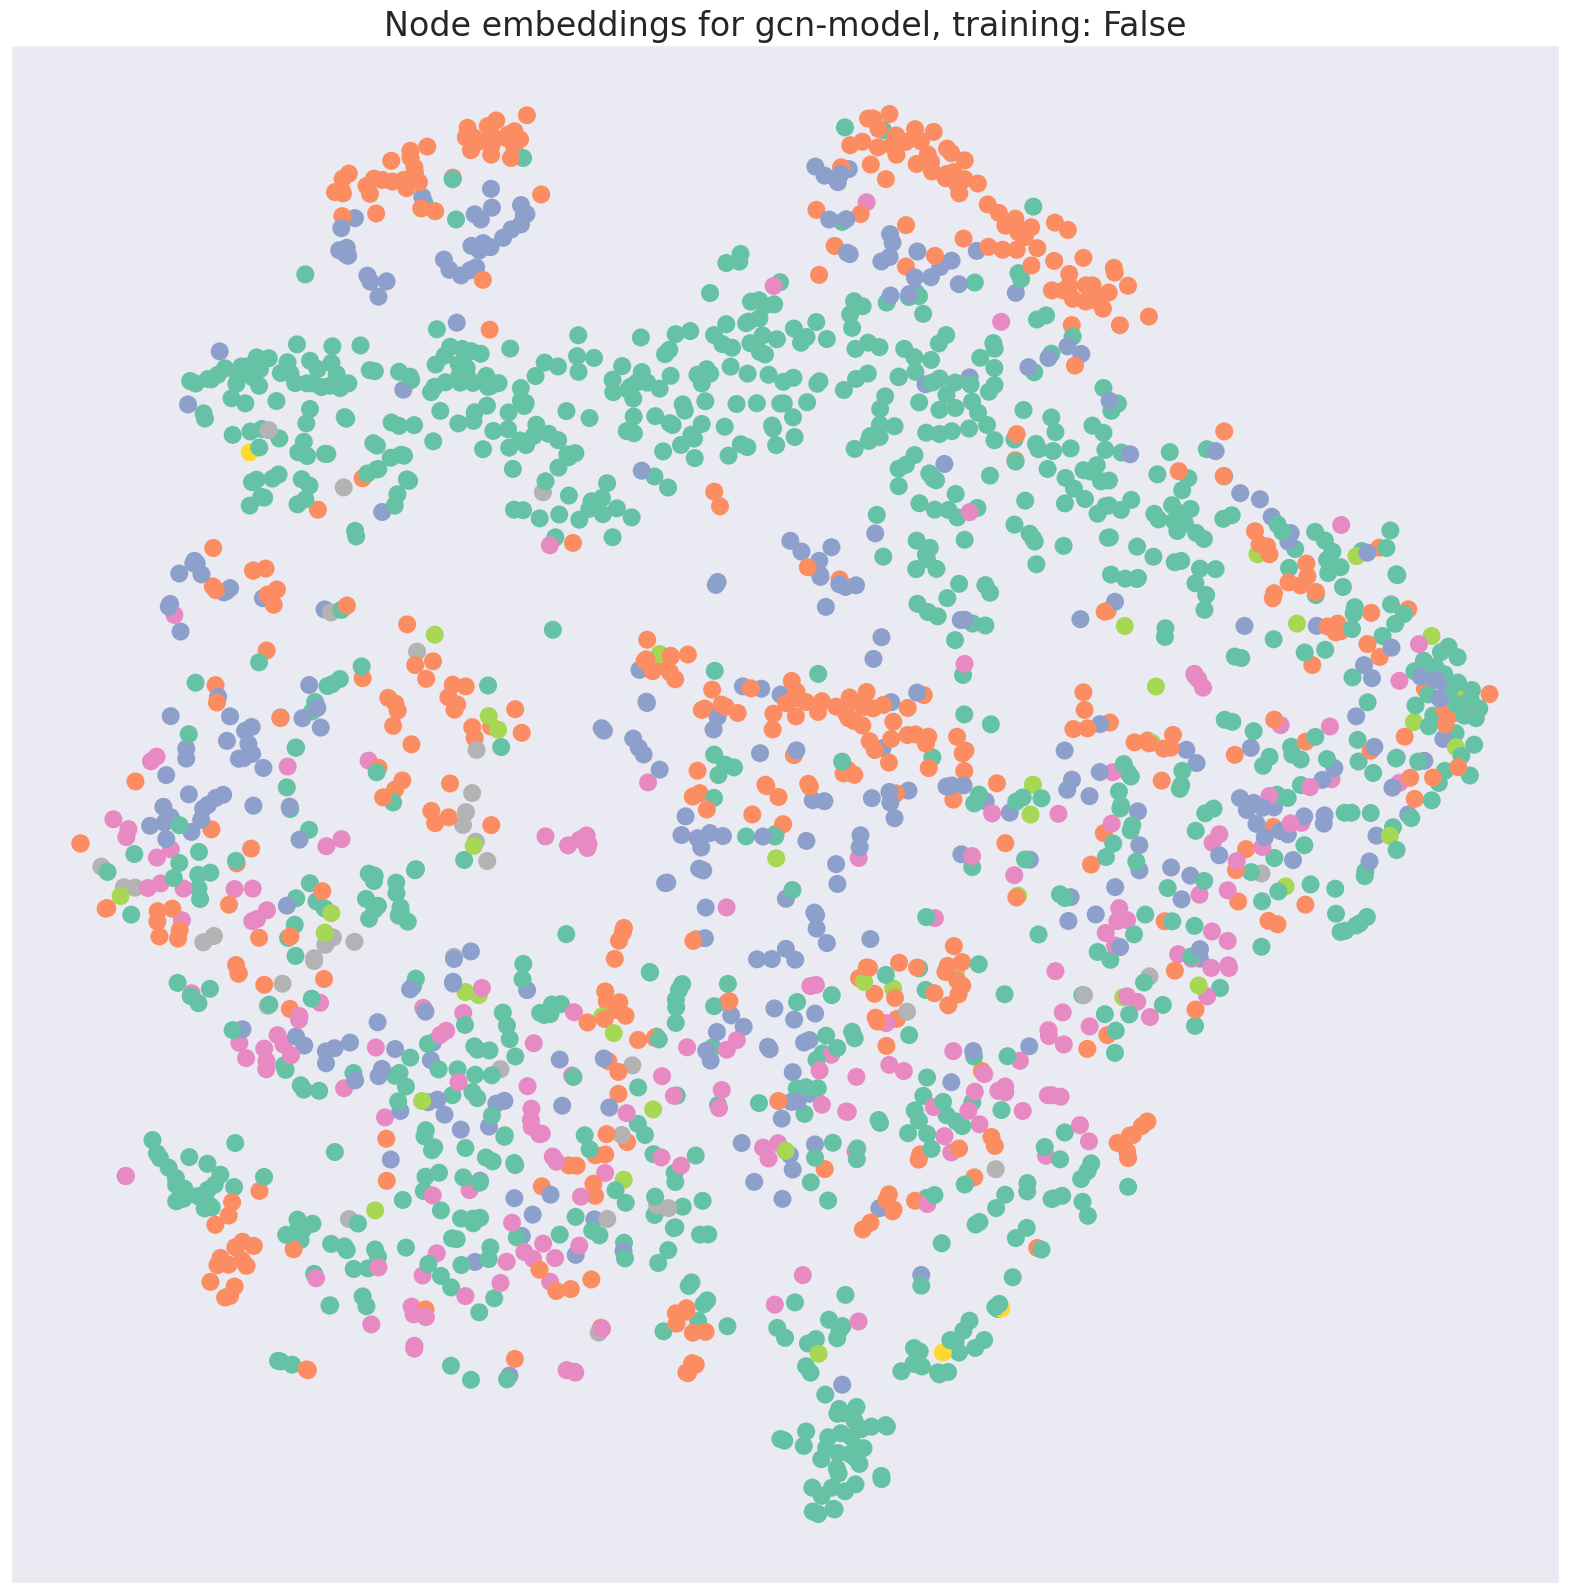

******************************* TESTING: *******************************
TEST ACCURACY: 0.65981


In [10]:
_, _ = gcn_process.test_loop_epoch()
gcn_process.train_val_loop(epochs)
gcn_process.plot_metrics()
pred_gcn, labels_gcn = gcn_process.test_loop_epoch()

In [11]:
#### TRAIN SAGE ##############################
sage_model = SAGE(dataset.num_features, dataset.num_classes, 128, 1, dropout_perc=0.6)
optimizer_sage = torch.optim.Adam(sage_model.parameters(), lr=0.0001)
sage_process = NetworkProcesser('sage', optimizer_sage, nn.CrossEntropyLoss(), sage_model, [train_loader, validation_loader, test_loader])
#############################################

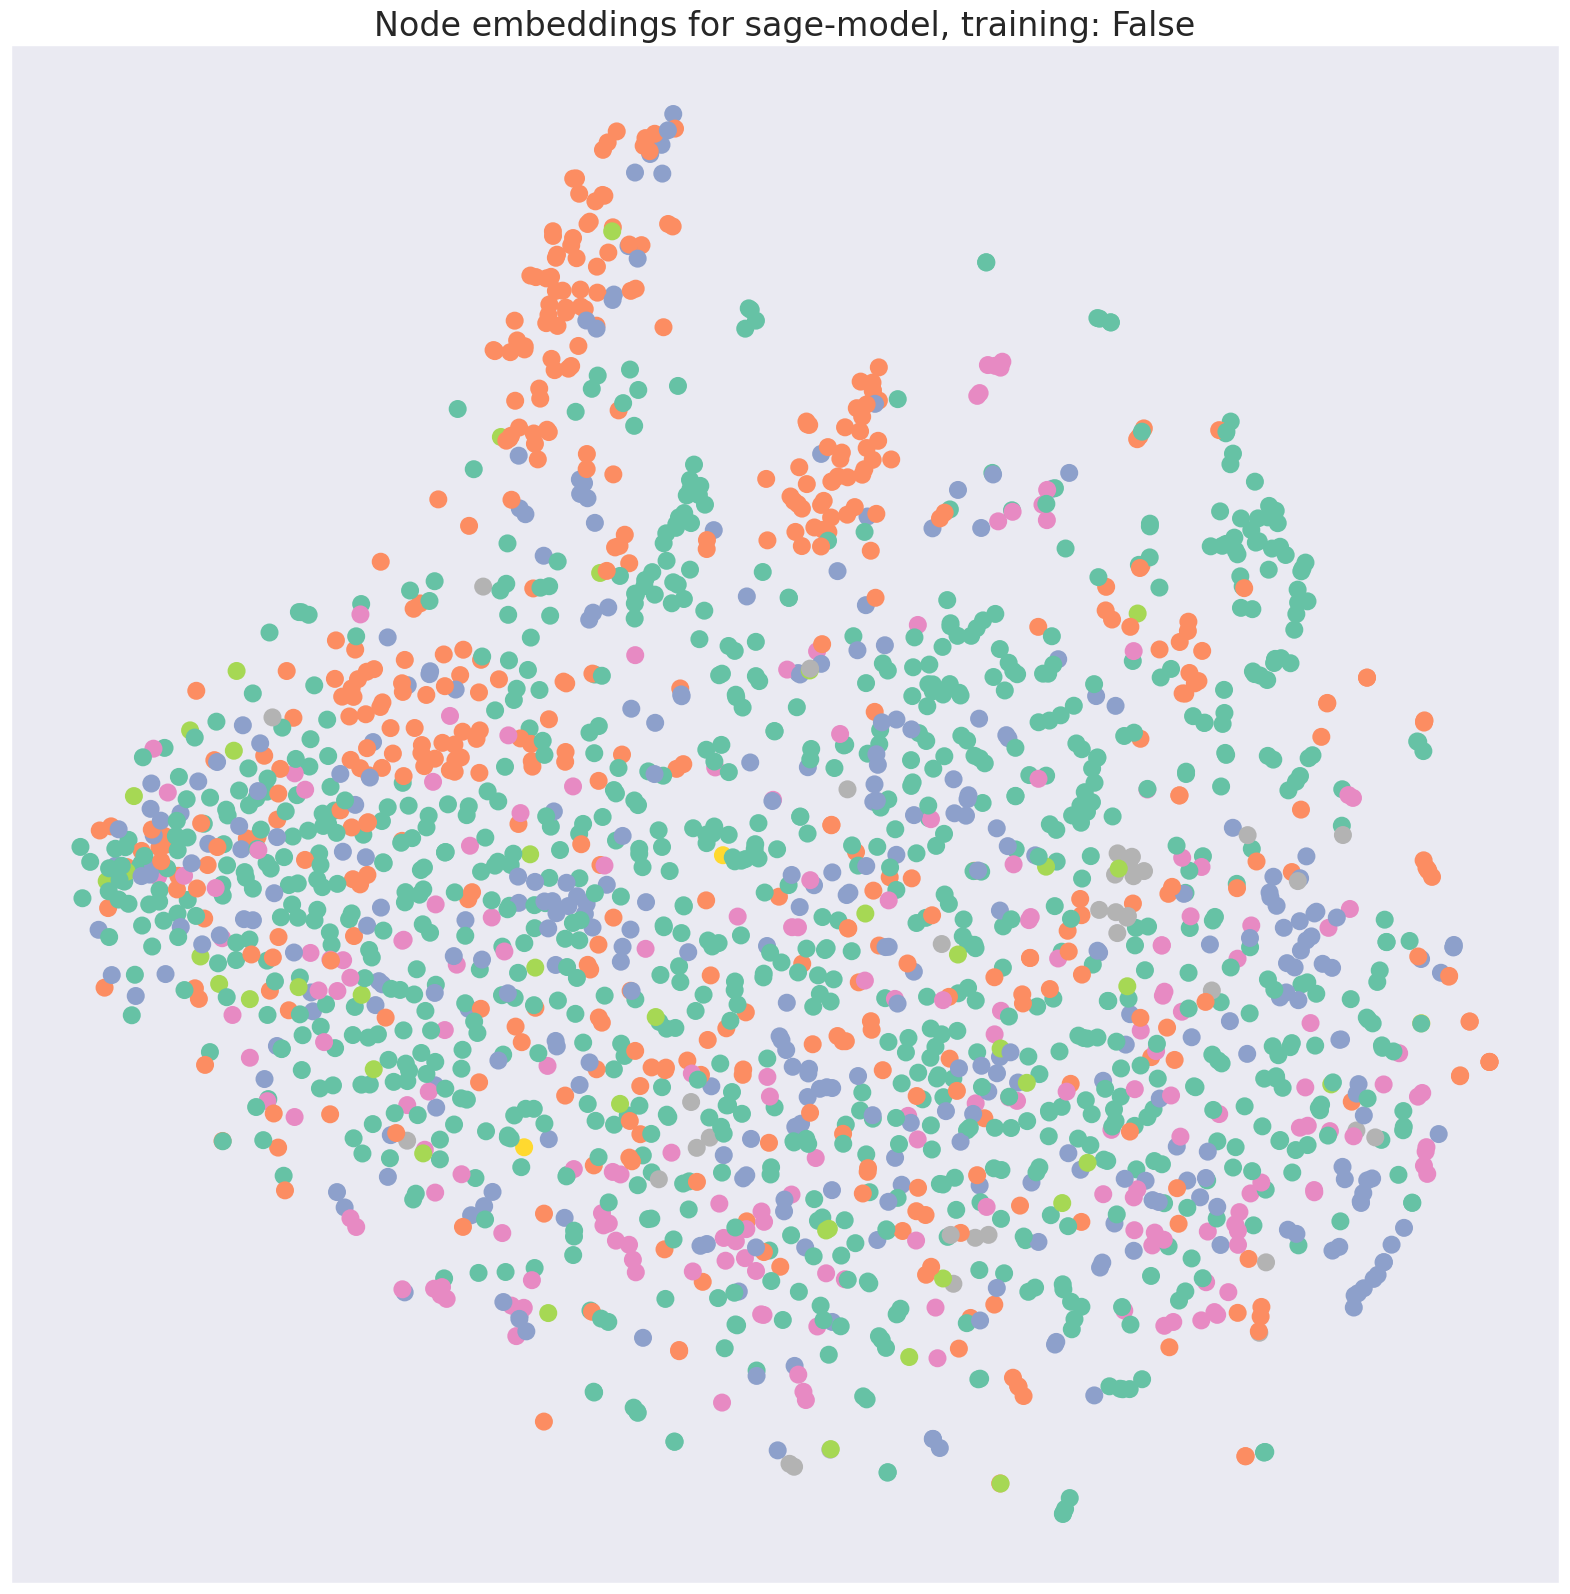

******************************* TESTING: *******************************
TEST ACCURACY: 0.03735
Starting training of sage on cuda : 
*************************************************************************************
Epoch 1 /:::/ TRAINING: Accuracy: 0.21617, Loss: 3.42397 /:::/ VALIDATION: Accuracy: 0.35619, Loss: 2.50483
*************************************************************************************
Epoch 2 /:::/ TRAINING: Accuracy: 0.44984, Loss: 2.23381 /:::/ VALIDATION: Accuracy: 0.41607, Loss: 2.65618
*************************************************************************************
Epoch 3 /:::/ TRAINING: Accuracy: 0.58734, Loss: 1.57234 /:::/ VALIDATION: Accuracy: 0.55855, Loss: 1.96029
*************************************************************************************
Epoch 4 /:::/ TRAINING: Accuracy: 0.67650, Loss: 1.24143 /:::/ VALIDATION: Accuracy: 0.64691, Loss: 1.52748
*************************************************************************************
Epoch

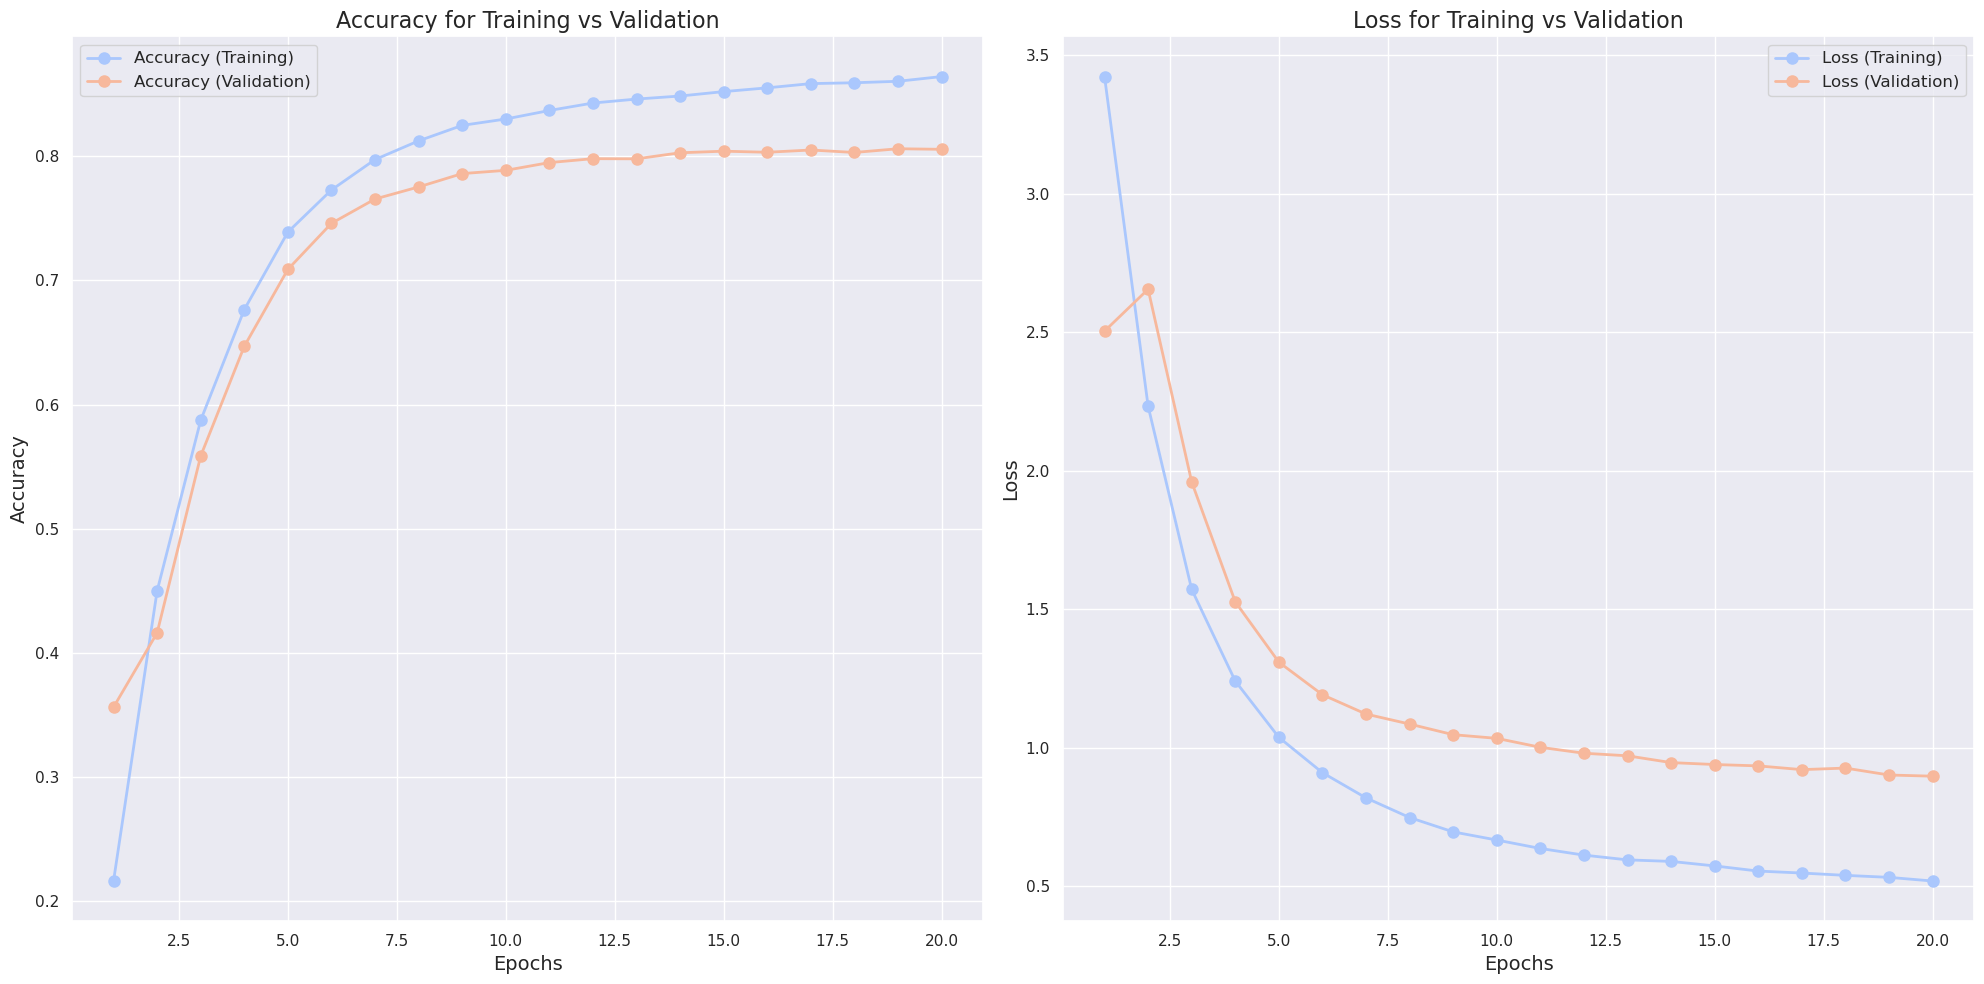

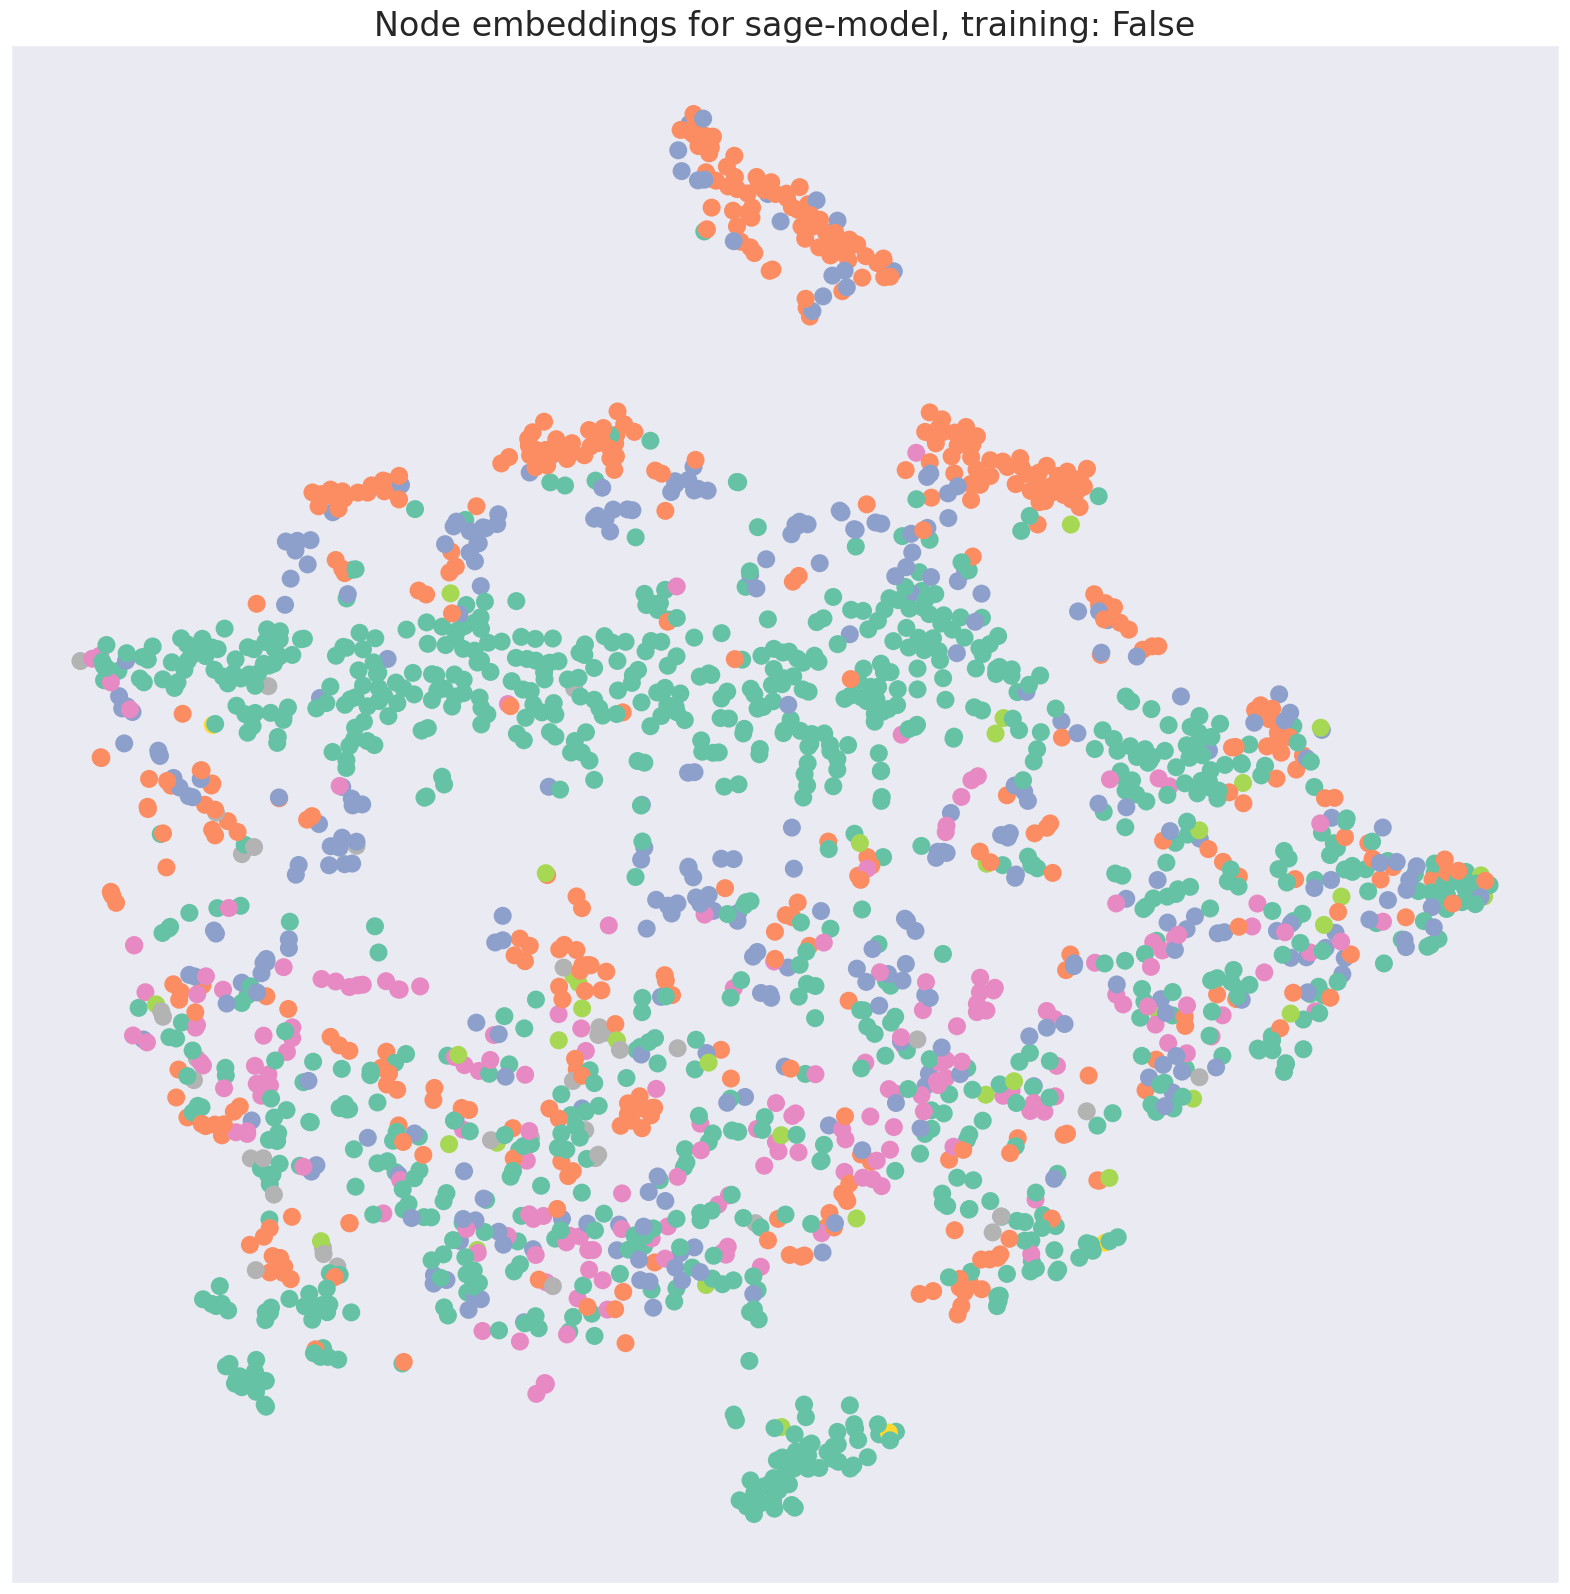

******************************* TESTING: *******************************
TEST ACCURACY: 0.63495


In [12]:
_, _ = sage_process.test_loop_epoch()
sage_process.train_val_loop(epochs)
sage_process.plot_metrics()
pred_sage, labels_sage = sage_process.test_loop_epoch()

In [18]:
## SAVE MODELS ##########
mlp_process.save_model()
gcn_process.save_model()
sage_process.save_model()

In [14]:
## These functions uses the library "pickle" to download results
def save_results(names, results):
    for name, res in zip(names, results):
        # Move the data to CPU if it's a tensor
        if isinstance(res, torch.Tensor):
            res = res.cpu()
        elif isinstance(res, list):  # If it's a list of tensors
            res = [d.cpu() if isinstance(d, torch.Tensor) else d for d in res]

        # Save the data on CPU to a new file
        with open(f'{name}_cpu.pkl', 'wb') as f:
            pickle.dump(res, f)

In [19]:
# Here we save all the relevant results from out code, ie training and validation accuracies as well our predicted and actual labels from our test set
save_results(['pred_gcn', 'labels_gcn'], [pred_gcn, labels_gcn])
save_results(['pred_mlp', 'labels_mlp'], [pred_mlp, labels_mlp])
save_results(['pred_sage', 'labels_sage'], [pred_sage, labels_sage])

save_results(['train_acc_gcn', 'val_acc_gcn'], [gcn_process.model_train_metric.accuracy, gcn_process.model_val_metric.accuracy])
save_results(['train_acc_mlp', 'val_acc_mlp'], [mlp_process.model_train_metric.accuracy, mlp_process.model_val_metric.accuracy])
save_results(['train_acc_sage', 'val_acc_sage'], [sage_process.model_train_metric.accuracy, sage_process.model_val_metric.accuracy])